# Import Libraries needed to run notebook

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# I. Create Simulated Dataset

### x values in spectrum (frequencies)

In [2]:
# Define x values
x = np.linspace(0, 1, 12)
x

array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
       0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
       0.90909091, 1.        ])

### number of fractional components

In [3]:
# Number of fractional components - rows in simulated dataset
fractional_components = np.linspace(0, 1, 101)
fractional_components

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

### Function 1 - exponential decay

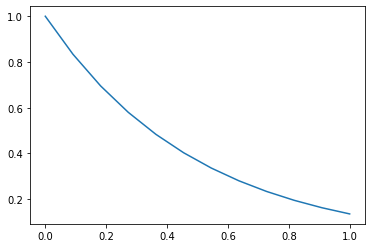

In [4]:
# Parameters for exponential decay
initial_val = 1
decay_factor = 2

# Create y
y_decay = initial_val*np.exp(-1*decay_factor*x)

# Plot
plt.plot(x, y_decay)

### Function 2 - exponential increase

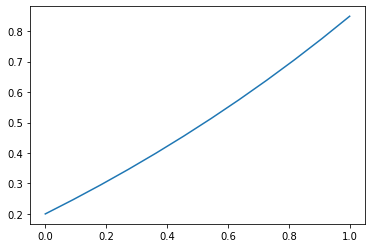

In [5]:
# Parameters for exponential decay
initial_val = 0.2

# Create y
y_exp = initial_val+(np.exp(x*.5)-1)

# Plot
plt.plot(x, y_exp)

### Function to create simulated dataset

In [6]:
# Function to create simulated dataset
def create_simulated_dataset(fractions, func_1, func_2, noise_sd):
    
    # Initialize list to hold dataset
    dat = []
    
    # Loop through to create dataset
    for fraction in fractions:
    
        # Define fractional components for each function
        function_1_fraction = fraction
        function_2_fraction = np.round(1 - fraction,2)
    
        # Multiply signal values by fraction
        func_1_fraction = func_1*function_1_fraction
        func_2_fraction = func_2*function_2_fraction
    
        # Add fractional signals together
        y_sum_fraction = func_1_fraction + func_2_fraction
        
        # Add random white gaussian noise to summed-spectrum
        noise = np.random.normal(0,noise_sd,len(y_sum_fraction))
        y_sum_fraction = y_sum_fraction + noise
    
        # Append result
        dat.append([function_1_fraction,
                    function_2_fraction] + list(y_sum_fraction))

    # Convert to dataframe
    dat = pd.DataFrame(dat,
                       columns = ['y1', 'y2',
                                  'x1', 'x2', 'x3', 'x4', 'x5', 'x6',
                                  'x7', 'x8', 'x9', 'x10', 'x11', 'x12'])
    
    # Return dataset
    return(dat)

In [7]:
# Create example dataset - no noise
simulated_dataset = create_simulated_dataset(fractional_components, y_decay, y_exp, 0)
simulated_dataset

,y1,y2,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,0.00,1.00,0.200,0.246503,0.295169,0.346099,0.399396,0.455172,0.513542,0.574626,0.638551,0.705449,0.775457,0.848721
1,0.01,0.99,0.208,0.252376,0.299169,0.348433,0.400234,0.454649,0.511766,0.571681,0.634501,0.700341,0.769326,0.841587
2,0.02,0.98,0.216,0.258248,0.303169,0.350768,0.401073,0.454127,0.509989,0.568735,0.630450,0.695233,0.763194,0.834454
3,0.03,0.97,0.224,0.264121,0.307169,0.353103,0.401911,0.453604,0.508213,0.565789,0.626400,0.690126,0.757063,0.827320
4,0.04,0.96,0.232,0.269993,0.311168,0.355438,0.402749,0.453081,0.506437,0.562844,0.622349,0.685018,0.750932,0.820186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.04,0.968,0.810263,0.679145,0.570239,0.479872,0.404982,0.343016,0.291849,0.249708,0.215117,0.186846,0.163871
97,0.97,0.03,0.976,0.816135,0.683145,0.572574,0.480710,0.404459,0.341240,0.288904,0.245658,0.210010,0.180715,0.156737
98,0.98,0.02,0.984,0.822008,0.687144,0.574909,0.481549,0.403936,0.339464,0.285958,0.241607,0.204902,0.174583,0.149603
99,0.99,0.01,0.992,0.827880,0.691144,0.577243,0.482387,0.403413,0.337687,0.283012,0.237557,0.199794,0.168452,0.142469


# II. spectral unmixing

## a) basic concept on single spectrum

### create X --> 100% Hb and 100% HbO<sub>2</sub> msot spectra

In [8]:
# Define X
y1_100 = np.squeeze(simulated_dataset.iloc[len(simulated_dataset)-1,
                                           2:].to_numpy())
y2_100 = np.squeeze(simulated_dataset.iloc[0,
                                           2:].to_numpy())

X = np.array([y1_100, y2_100]).T
X

array([[1.        , 0.2       ],
       [0.83375292, 0.24650344],
       [0.69514393, 0.29516944],
       [0.57957828, 0.34609858],
       [0.48322508, 0.3993961 ],
       [0.40289032, 0.45517214],
       [0.33591098, 0.51354196],
       [0.28006676, 0.57462617],
       [0.23350648, 0.63855101],
       [0.19468671, 0.70544857],
       [0.16232061, 0.7754571 ],
       [0.13533528, 0.84872127]])

### create y --> msot spectra at user defined fractional components

In [9]:
# User defined y signal at given y1, y2 fractional components
y1_frac = 0.32 # User defined
dat_temp = simulated_dataset.loc[simulated_dataset['y1']==y1_frac].copy()
y = np.squeeze(dat_temp.iloc[:,2:].to_numpy())
y

array([0.456     , 0.43442327, 0.42316128, 0.42081208, 0.42622138,
       0.43844196, 0.45670004, 0.48036716, 0.50893676, 0.54200478,
       0.57925343, 0.62043775])

### estimate fractional components of y using spectral unmixing

In [10]:
# Use spectral unmixing to get fractional components
linear_regressor = LinearRegression(fit_intercept=False)
linear_regressor.fit(X, y)

# Estimated fractional components (y1_frac, y2_frac)
y1_estimate, y2_estimate = linear_regressor.coef_

print('y1 estimate: ' + str(np.round(y1_estimate,2)))
print('y2 estimate: ' + str(np.round(y2_estimate,2)))

y1 estimate: 0.32
y2 estimate: 0.68


### estimated components of y1 and y2 in msot spectrum

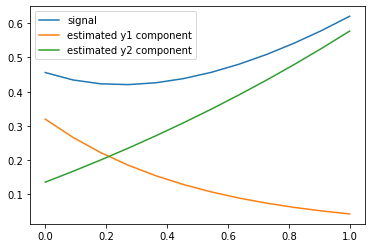

In [11]:
# Plot
plt.plot(x, y, label = "signal") # Raw Signal

# y signals for each components based on regression estimates
## y1
y1_frac = y1_estimate
y1_signal = y_decay*y1_frac
plt.plot(x, y1_signal, label = "estimated y1 component")
## y2
y2_frac = y2_estimate
y2_signal = y_exp*y2_frac
plt.plot(x, y2_signal, label = "estimated y2 component")

# Plot
plt.legend()
plt.show()

## b) calculate rmse of estimates on all spectra in dataset

In [12]:
# Define actual y1s and y2s
y1s = list(simulated_dataset['y1'].values)
y2s = list(simulated_dataset['y2'].values)

# Preallocate lists to hold y1 and y2 estimates
y1_estimates = []
y2_estimates = []

# Define linear regressor
linear_regressor = LinearRegression(fit_intercept=False, positive=True)

# Loop through each spectrum and estimate y1 and y2 using spectral unmixing
for spectrum_iterator in range(len(simulated_dataset)):
    y = np.squeeze(simulated_dataset.iloc[spectrum_iterator,
                                          2:].to_numpy())
    # Use spectral unmixing to get fractional components
    linear_regressor.fit(X, y)

    # Estimated fractional components (y1_frac, y2_frac)
    y1_estimate, y2_estimate = linear_regressor.coef_
    
    # Append results
    y1_estimates.append(y1_estimate)
    y2_estimates.append(y2_estimate)
    
# Calculate rmse for y1 and y2
rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                             squared=False)
print('rmse_y1: ' + str(rmse_y1))
rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                             squared=False)
print('rmse_y2: ' + str(rmse_y2))

rmse_y1: 2.0027070464350204e-16
rmse_y2: 1.3202777927530697e-16


In [13]:
# Calculate average rmse
avg_rmse = (rmse_y1 + rmse_y2)/2
print('average rmse: ' + str(avg_rmse))

average rmse: 1.661492419594045e-16


## c) full simulated experiment

In [14]:
# Initialize result array
results = []

# Define linear regressor
linear_regressor = LinearRegression(fit_intercept=False, positive=True)

# Define noise levels
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
for noise_level in noise_levels:
    
    # Define number of repetitions
    reps = np.linspace(1, 100, 100)
    for rep in reps:
        
        # Create simulated dataset
        simulated_dataset = create_simulated_dataset(fractional_components, 
                                                     y_decay, 
                                                     y_exp, 
                                                     noise_level)
        
        # Define actual y1s and y2s
        y1s = list(simulated_dataset['y1'].values)
        y2s = list(simulated_dataset['y2'].values)

        # Preallocate lists to hold y1 and y2 estimates
        y1_estimates = []
        y2_estimates = []

        # Loop through each spectrum and estimate y1 and y2 using spectral unmixing
        for spectrum_iterator in range(len(simulated_dataset)):
            y = np.squeeze(simulated_dataset.iloc[spectrum_iterator,
                                                  2:].to_numpy())
            # Use spectral unmixing to get fractional components
            linear_regressor.fit(X, y)

            # Estimated fractional components (y1_frac, y2_frac)
            y1_estimate, y2_estimate = linear_regressor.coef_
    
            # Append results
            y1_estimates.append(y1_estimate)
            y2_estimates.append(y2_estimate)
    
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
            
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
            
        # Append results
        results.append([noise_level, rep, avg_rmse])

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 'rep', 'avg_rmse'])
results

,noise_level,rep,avg_rmse
0,0.0,1.0,1.661492e-16
1,0.0,2.0,1.661492e-16
2,0.0,3.0,1.661492e-16
3,0.0,4.0,1.661492e-16
4,0.0,5.0,1.661492e-16
...,...,...,...
495,0.2,96.0,1.383415e-01
496,0.2,97.0,1.245685e-01
497,0.2,98.0,1.311276e-01
498,0.2,99.0,1.306760e-01


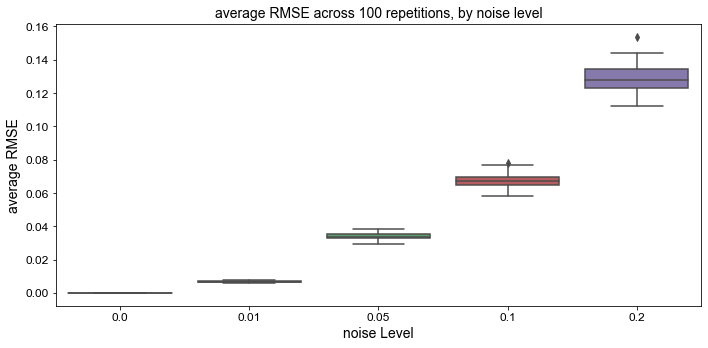

In [15]:
# Box Plot of result
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', data = results)
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("average RMSE",
              fontsize=14)
ax.set_title("average RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

# III. machine learning

In [7]:
# Create X - no noise for training
simulated_dataset = create_simulated_dataset(fractional_components, y_decay, y_exp, 0)
X = simulated_dataset.iloc[:, 2:].values
X

array([[0.2       , 0.24650344, 0.29516944, ..., 0.70544857, 0.7754571 ,
        0.84872127],
       [0.208     , 0.25237593, 0.29916918, ..., 0.70034095, 0.76932574,
        0.84158741],
       [0.216     , 0.25824842, 0.30316893, ..., 0.69523334, 0.76319437,
        0.83445355],
       ...,
       [0.984     , 0.82200793, 0.68714444, ..., 0.20490195, 0.17458334,
        0.149603  ],
       [0.992     , 0.82788042, 0.69114418, ..., 0.19979433, 0.16845198,
        0.14246914],
       [1.        , 0.83375292, 0.69514393, ..., 0.19468671, 0.16232061,
        0.13533528]])

In [8]:
# Create y
y = simulated_dataset.iloc[:, 0:2].values
y

array([[0.  , 1.  ],
       [0.01, 0.99],
       [0.02, 0.98],
       [0.03, 0.97],
       [0.04, 0.96],
       [0.05, 0.95],
       [0.06, 0.94],
       [0.07, 0.93],
       [0.08, 0.92],
       [0.09, 0.91],
       [0.1 , 0.9 ],
       [0.11, 0.89],
       [0.12, 0.88],
       [0.13, 0.87],
       [0.14, 0.86],
       [0.15, 0.85],
       [0.16, 0.84],
       [0.17, 0.83],
       [0.18, 0.82],
       [0.19, 0.81],
       [0.2 , 0.8 ],
       [0.21, 0.79],
       [0.22, 0.78],
       [0.23, 0.77],
       [0.24, 0.76],
       [0.25, 0.75],
       [0.26, 0.74],
       [0.27, 0.73],
       [0.28, 0.72],
       [0.29, 0.71],
       [0.3 , 0.7 ],
       [0.31, 0.69],
       [0.32, 0.68],
       [0.33, 0.67],
       [0.34, 0.66],
       [0.35, 0.65],
       [0.36, 0.64],
       [0.37, 0.63],
       [0.38, 0.62],
       [0.39, 0.61],
       [0.4 , 0.6 ],
       [0.41, 0.59],
       [0.42, 0.58],
       [0.43, 0.57],
       [0.44, 0.56],
       [0.45, 0.55],
       [0.46, 0.54],
       [0.47,

## a) Linear Regression

In [9]:
# Train model on clean data
model = LinearRegression(positive=True)
model.fit(X, y)
model

LinearRegression(positive=True)

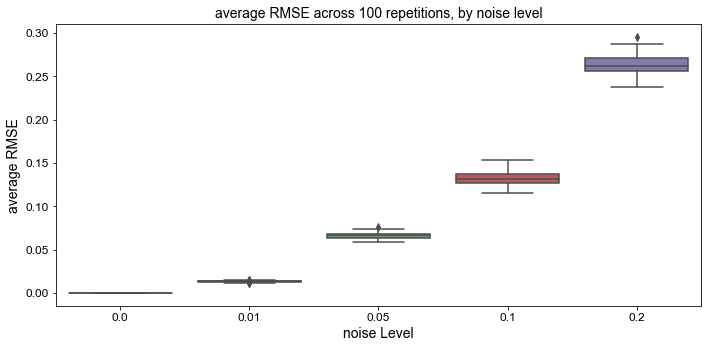

In [10]:
# Initialize result array
results = []

# Define noise levels
noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
for noise_level in noise_levels:
    
    # Define number of repetitions
    reps = np.linspace(1, 100, 100)
    for rep in reps:
        
        # Create simulated dataset
        simulated_dataset = create_simulated_dataset(fractional_components, 
                                                     y_decay, 
                                                     y_exp, 
                                                     noise_level)
        
        # Define actual y1s and y2s
        y1s = list(simulated_dataset['y1'].values)
        y2s = list(simulated_dataset['y2'].values)

        # Estimated y1s and y2s
        yhat = model.predict(simulated_dataset.iloc[:, 2:].values)
        y1_estimates = list(yhat[:,0])
        y2_estimates = list(yhat[:,1])
    
        # Calculate rmse for y1 and y2
        rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                     squared=False)
        rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                     squared=False)
            
        # Calculate average rmse
        avg_rmse = (rmse_y1 + rmse_y2)/2
            
        # Append results
        results.append([noise_level, rep, avg_rmse])

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 'rep', 'avg_rmse'])

# Box Plot of result
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', data = results)
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("average RMSE",
              fontsize=14)
ax.set_title("average RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()

## b) Ridge

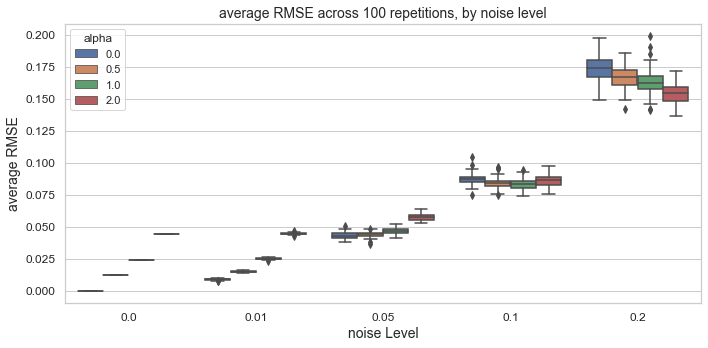

In [11]:
# Initialize result array
results = []

# Define alphas
alphas = [0, 0.5, 1, 2]
for alpha in alphas:
    model = Ridge(positive=True, alpha = alpha)
    model.fit(X, y)

    # Define noise levels
    noise_levels = [0, 0.01, 0.05, 0.1, 0.2]
    for noise_level in noise_levels:
    
        # Define number of repetitions
        reps = np.linspace(1, 100, 100)
        for rep in reps:
        
            # Create simulated dataset
            simulated_dataset = create_simulated_dataset(fractional_components, 
                                                         y_decay, 
                                                         y_exp, 
                                                         noise_level)
        
            # Define actual y1s and y2s
            y1s = list(simulated_dataset['y1'].values)
            y2s = list(simulated_dataset['y2'].values)

            # Estimated y1s and y2s
            yhat = model.predict(simulated_dataset.iloc[:, 2:].values)
            y1_estimates = list(yhat[:,0])
            y2_estimates = list(yhat[:,1])
    
            # Calculate rmse for y1 and y2
            rmse_y1 = mean_squared_error(np.array(y1s), np.array(y1_estimates), 
                                         squared=False)
            rmse_y2 = mean_squared_error(np.array(y2s), np.array(y2_estimates), 
                                         squared=False)
            
            # Calculate average rmse
            avg_rmse = (rmse_y1 + rmse_y2)/2
            
            # Append results
            results.append([noise_level, rep, avg_rmse, alpha])

# Save results as dataframe
results = pd.DataFrame(results, 
                       columns = ['noise_level', 'rep', 'avg_rmse', 'alpha'])

# Box Plot of result
fig, ax = plt.subplots(figsize = (10,5))
sns.set(style="whitegrid")
sns.boxplot(x='noise_level', y='avg_rmse', hue='alpha',
            data = results)
ax.set_xlabel("noise Level",
              fontsize=14)
ax.set_ylabel("average RMSE",
              fontsize=14)
ax.set_title("average RMSE across 100 repetitions, by noise level",
             fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig.tight_layout()
plt.show()